Domino Optimization Art

The concept for this algorithm comes from Robert Bosch "Opt Art", Princeton University Press (c) 2019.

The artwork used in this analysis comes from Arc System Work's Guilty Gear Strive website, (c) 2020-2021.

This implementation in Python is written by Ryan Ruff, (c) 2021.

In [1]:
# install prereqs as needed
#!pip3 install matplotlib
#!pip3 install pulp

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpMinimize, PULP_CBC_CMD, value
from IPython.core.display import HTML

In [3]:
# set up some configuration variables for later
default_config = {"sets":4,
                  "max_pips":9,
                  "set_size":55,
                  "width":20,
                  "dot_radius":2,
                  "divider_width":1,
                  "foreground":"white",
                  "background":"black"}

# by "pips", I mean the number of dots on the dominoes
# each of these is an ordered pair [i,j] with j<=i
default_config["pips"] = []
for i in range(10):
    for j in range(i+1):
        default_config["pips"].append([i,j])
        
assert len(default_config["pips"])==default_config["set_size"] 
        
# each pip is represented visually with a dot
# 0 1 2
# 3 4 5
# 6 7 8
default_config["dot_coords"] = []
for i in range(3):
    for j in range(3):
        default_config["dot_coords"].append([(i+1)/4,(j+1)/4])

# even though there's 9 potention dots, the domino can also be "blank"
# so there's actually one more value than the max pips
default_config["dots_by_pip"] = [[],[4],[0,8],[0,4,8],[0,2,6,8],[0,2,4,6,8],[0,1,2,6,7,8],[0,1,2,4,6,7,8],[0,1,2,3,5,6,7,8],[0,1,2,3,4,5,6,7,8]]
assert len(default_config["dots_by_pip"])==default_config["max_pips"]+1




In [4]:
# Uncomment out to grab image sources as needed
# sol has to be an odd ball...
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_kyk.jpg    
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_may-1.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_axl.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_chp.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_pot.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_fau.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_mll.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_zat.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_ram-1.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_leo.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_nag.jpg
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2020/09/archive_gio.jpg
#more oddballs
#anji
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2021/03/anji-306x305.jpg
#I-no
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2021/03/rxx82us-1-306x305.jpg
#Goldlewis
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2021/07/gol-306x305.jpg
#jack-o
#!wget https://www.guiltygear.com/ggst/en/wordpress/wp-content/uploads/2021/08/jko.jpg

In [5]:
# Map Chars to files
guilty_gear_cast = {"Sol":"archive.jpg", "Ky":"archive_kyk.jpg","May":"archive_may-1.jpg", 
                   "Axl":"archive_axl.jpg", "Chipp":"archive_chp.jpg", "Potemkin":"archive_pot.jpg",
                   "Faust":"archive_fau.jpg", "Millia":"archive_mll.jpg", "Zato":"archive_zat.jpg",
                   "Ramlethal":"archive_ram-1.jpg", "Leo":"archive_leo.jpg", "Nagoriyuki":"archive_nag.jpg",
                   "Giovanna":"archive_gio.jpg", "Anji":"anji-306x305.jpg", "I-no":"rxx82us-1-306x305.jpg",
                   "Goldlewis":"gol-306x305.jpg","Jack-O":"jko.jpg"}

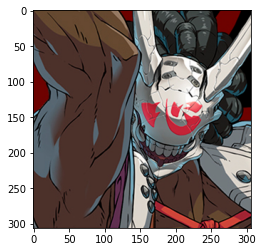

In [6]:
# I'm a Nago main, so he's gonna be my test subject
# Read Image
img = mpimg.imread(guilty_gear_cast["Nagoriyuki"])
# Output Image
plt.imshow(img)

In [7]:
img.shape

(306, 306, 3)

In [8]:
# i'm using a simple vector norm to convert to greyscale
# todo: check if variations here would look better
def convert_image_to_grayscale(i):
    return np.sqrt(i.dot(np.full(i.shape[2],1)))
grayscale = convert_image_to_grayscale(img)

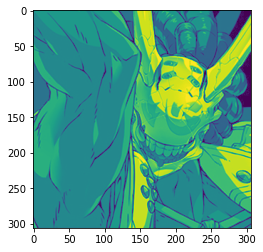

In [9]:
plt.imshow(grayscale)

In [10]:
# first, we'll need to see how closely we can mimic the shape of the originial image with
# however many dominioes we're using

def get_factors(x):
    max_factor = int(np.floor(np.sqrt(x)))
    outputs = set()
    for i in range(1,max_factor+1):
        if (x%i == 0):
            outputs.add(i)
            outputs.add(int(x/i))
    return outputs

def find_best_dim(image_source,config):
    # use the relative area to find a scale factor
    aspect_ratio = image_source.shape[0]/image_source.shape[1]
    num_dominoes = config["sets"]*config["set_size"]
    dominoes_area = num_dominoes*2
    
    img_area = image_source.shape[0]*image_source.shape[1]
    area_ratio = img_area / dominoes_area
    scale_factor = np.sqrt(area_ratio)
    
    # now give us a decimal size that's the appropriate scale
    scale_vector = image_source.shape/scale_factor
       
    # approximate that shape using integer factors
    col_vec = [int(dominoes_area),1]
    col_dis = np.linalg.norm(scale_vector-col_vec)
    row_vec = [1,int(dominoes_area)]
    row_dis = np.linalg.norm(scale_vector-row_vec)
    best_vec = col_vec if col_dis <= row_dis else row_vec
    best_dis = min(col_dis,row_dis)
    
    for factor in list(get_factors(dominoes_area)):
        vec = [int(dominoes_area/factor),factor]
        dis = np.linalg.norm(scale_vector-vec)
        if (dis < best_dis):
            best_dis = dis
            best_vec = vec
    return best_vec
    

In [11]:
best_vec = find_best_dim(grayscale,default_config)
print(best_vec)

[22, 20]


In [12]:
# now we know how big our ouput tiling should be
best_vec


[22, 20]

In [13]:
# our next big step is to make the sizes match up
def resample_image(image_source,target_dim):
    desired_height = target_dim[0]
    #print(desired_height)
    desired_width = target_dim[1]
    #print(desired_width)
    desired_aspect_ratio = desired_height/desired_width
    
    # start by padding the image to a multiple of the base dimensions
    #print(desired_aspect_ratio)
    padded_scale = int(np.ceil(max(image_source.shape[0]/desired_height,image_source.shape[1]/desired_width)))
    #print(padded_scale)
    padded_shape = np.array([desired_height * padded_scale, desired_width * padded_scale])
    #print(padded_shape)
    padding_dim = padded_shape-image_source.shape
    #print(padding_dim)
    left_pad = int(np.floor(padding_dim[0]/2.0))
    #print(left_pad)
    right_pad = int(np.ceil(padding_dim[0]/2.0))
    #print(right_pad)
    top_pad = int(np.floor(padding_dim[1]/2.0))
    #print(top_pad)
    bottom_pad = int(np.ceil(padding_dim[1]/2.0))
    #print(bottom_pad)
    
    padded_image = np.pad(image_source,[[left_pad,right_pad],[top_pad,bottom_pad]],mode="edge")
    #print(padded_image.shape)
    # next, take a simple convolution to add up the cells in each block
    lowres_image = np.full([desired_height,desired_width],0)
    left_ones = np.full([1,padded_scale],1.0)
    right_ones = np.full([padded_scale,1],1.0)
    for i in range(desired_height):
        row_start = i*padded_scale
        row_end = row_start+padded_scale
        for j in range(desired_width):
            col_start = j*padded_scale
            col_end = col_start + padded_scale
            submatrix = padded_image[row_start:row_end,col_start:col_end]
            lowres_image[i,j] = left_ones.dot(submatrix.dot(right_ones))
    return  lowres_image
        
    
    

In [14]:
grayscale_lowres = resample_image(grayscale,best_vec)



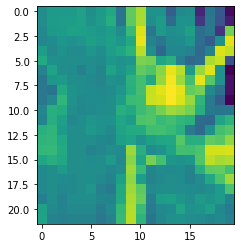

In [15]:
plt.imshow(grayscale_lowres)

In [16]:
def normalize_image(image_source,max_value=9):
    lowres_area = image_source.shape[0]*image_source.shape[1]
    flattened_image = image_source.reshape(lowres_area,1)
    img_mean = np.mean(flattened_image)
    img_min = np.min(flattened_image)
    img_max = np.max(flattened_image)
    #print("mean: {}, min: {}, max: {}".format(img_mean,img_min,img_max))
    # I think Bosch chose to round here also, but I kind of like the idea of keeping the fractions around for now
    return (image_source - np.full(image_source.shape,img_min)) / (img_max-img_min) * max_value

In [17]:
normalized_lowres = normalize_image(grayscale_lowres)

print(normalized_lowres)


[[4.39822075 4.83383595 4.85962002 4.85554885 5.13374548 4.48778649
  4.84604946 5.4119421  3.4252111  6.78799759 7.83835947 4.57599517
  4.55428227 2.71004222 4.23944511 4.43486128 0.92551267 3.49442099
  2.48884198 0.25648372]
 [4.44571773 4.93832931 4.99668275 5.00211098 5.14053076 4.58820869
  4.95597105 5.61007238 3.51341978 6.76899879 7.86007238 4.49728589
  4.96004222 3.1931544  4.58006634 4.56378166 1.43983715 3.56227382
  2.3816345  0.67310012]
 [4.2462304  4.89354644 4.93425814 5.1581725  5.06317853 4.9763269
  4.74834138 5.05639324 4.34258142 6.10268396 8.51145959 3.5473462
  4.91933052 4.428076   4.55835344 5.13238842 3.21486731 3.63148372
  1.34891435 7.11097708]
 [4.14987937 4.37922195 4.73205669 4.56920989 4.70762967 5.10931846
  4.86776236 5.13238842 4.7225573  5.45808203 8.70280458 4.00738842
  3.54870326 4.27337153 4.39007841 4.77819662 3.23929433 2.62047648
  4.5094994  8.62273824]
 [5.06182147 4.24894451 4.58820869 4.33172497 4.3588661  4.69405911
  4.40229192 5.026

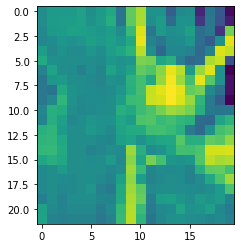

In [18]:
plt.imshow(normalized_lowres)

In [19]:
# okay, lets try an easier LP first to make sure my solver works
# we'll force all dominoes to be horizontal or vertical

# since there's only two posible orientions, we can define the cost function
# to take the lower of the two possible differences
def cost_function_fixed_orientation(D,R,C,axis,image_source,config):
    v0 = np.array(config["pips"][D])
    my_target = []
    # check if our slots are vertical
    if (axis == 0):
        my_target.append(int(image_source[2*R,C]))
        my_target.append(int(image_source[2*R+1,C]))
    else:
        #horizontal slots
        my_target.append(int(image_source[R,2*C]))
        my_target.append(int(image_source[R,2*C+1]))
    v1 = np.array(my_target)
    v2 = np.array([my_target[1],my_target[0]])
    d0 = v1-v0
    d1 = v2-v0
    return np.min([np.inner(d0,d0),np.inner(d1,d1)])





In [20]:
# configure and solve a model using pulp
def solve_for_fixed_orientation(image_source,config):
    # 1st, check which dimension we can half it along
    print("Configuring Solver:\n")
    
    print(image_source.shape)
    desired_height = image_source.shape[0]
    desired_width = image_source.shape[1]
    split_dim = 1
    if (desired_height % 2 == 0):
        split_dim = 0
    print(split_dim)

    # this cuts our "slots" to half the output
    slot_dim = [image_source.shape[0],image_source.shape[1]]
    slot_dim[split_dim] = int(slot_dim[split_dim]/2)
    print(slot_dim)

    # now we leverage pulp to solve it
    # create a problem
    prob = LpProblem("Domino_Art_Fixed_Orientation", LpMinimize)
    # create our variables
    DOMINOS = range(config["set_size"])
    ROWS = range(slot_dim[0])
    COLS = range(slot_dim[1])
    # each combination of these represents a binary choice variable
    choices = LpVariable.dicts("VARS", (DOMINOS,ROWS,COLS), cat="Binary")
    
    #calculate our costs in an array
    cost_array = []
    for d in DOMINOS:
        c_dom = []
        for r in ROWS:
            c_row = []
            for c in COLS:
                c_row.append(cost_function_fixed_orientation(d,r,c,split_dim,image_source,config))
            c_dom.append(c_row)
        cost_array.append(c_dom)
    
    # use this cost array to specify the objective function
    prob += lpSum([cost_array[d][r][c]*choices[d][r][c] 
               for d in DOMINOS
               for r in ROWS
               for c in COLS])
    
    # constraint 1: exactly 'domino_sets' copies of each domino
    # --- dim:'dominoes_per_set' (55)
    #    belongs in Aeq:  55 x num_variables
    for d in DOMINOS:
        prob += lpSum([choices[d][r][c]
                       for r in ROWS
                       for c in COLS]) == config["sets"]
    # constraint 2: every slot must have exactly one domino
    for r in ROWS:
        for c in COLS:
            prob += lpSum([choices[d][r][c] for d in DOMINOS]) == 1
    
    solver = PULP_CBC_CMD(keepFiles=True)
    prob.solve(solver)
    
    if (prob.status < 0):
        return None
    # okay, even though we "solved" it, we still need to go through and decide which of the two orientations is best
    # while we're doing that, turn them into a format I can render more easily
    solutions = []
    for d in DOMINOS:
        for r in ROWS:
            for c in COLS:
                if (value(choices[d][r][c]) == 1.0):
                    solutions.append([d,r,c])

    render_out = []
    for s in solutions:
        v0 = np.array(default_config["pips"][s[0]])
        my_target = []
        # check if our slots are vertical
        if (split_dim == 0):
            my_target.append(int(image_source[2*s[1],s[2]]))
            my_target.append(int(image_source[2*s[1]+1,s[2]]))
        else:
            #horizontal slots
            my_target.append(int(image_source[s[1],2*s[2]]))
            my_target.append(int(image_source[s[1],2*s[2]+1]))
        v1 = np.array(my_target)
        v2 = np.array([my_target[1],my_target[0]])
        d0 = v1-v0
        d1 = v2-v0
        if (np.inner(d0,d0)<np.inner(d1,d1)):# original orientation is better
            if (split_dim == 0):#vertical slots
                render_out.append([config["pips"][s[0]],2*s[1],s[2],0])
            else:#horizontal slots
                render_out.append([config["pips"][s[0]],s[1],2*s[2],1])
        else: # rotate 180
            if (split_dim == 0):#vertical slots
                render_out.append([config["pips"][s[0]],2*s[1]+1,s[2],2])
            else:#horizontal slots
                render_out.append([config["pips"][s[0]],s[1],2*s[2]+1,3])

    return render_out

In [21]:
# test it out!
fixed_orientation_solutions = solve_for_fixed_orientation(normalized_lowres,default_config)
len(fixed_orientation_solutions)



Configuring Solver:

(22, 20)
0
[11, 20]


220

In [22]:
fixed_orientation_solutions

[[[0, 0], 1, 16, 2],
 [[0, 0], 1, 19, 2],
 [[0, 0], 7, 19, 2],
 [[0, 0], 9, 19, 2],
 [[1, 0], 1, 18, 2],
 [[1, 0], 9, 0, 2],
 [[1, 0], 11, 17, 2],
 [[1, 0], 21, 6, 2],
 [[1, 1], 1, 8, 2],
 [[1, 1], 3, 16, 2],
 [[1, 1], 5, 15, 2],
 [[1, 1], 5, 16, 2],
 [[2, 0], 1, 13, 2],
 [[2, 0], 1, 17, 2],
 [[2, 0], 8, 18, 0],
 [[2, 0], 21, 11, 2],
 [[2, 1], 3, 1, 2],
 [[2, 1], 19, 2, 2],
 [[2, 1], 21, 1, 2],
 [[2, 1], 21, 19, 2],
 [[2, 2], 1, 12, 2],
 [[2, 2], 5, 2, 2],
 [[2, 2], 17, 0, 2],
 [[2, 2], 21, 3, 2],
 [[3, 0], 2, 17, 0],
 [[3, 0], 4, 14, 0],
 [[3, 0], 9, 4, 2],
 [[3, 0], 20, 2, 0],
 [[3, 1], 1, 2, 2],
 [[3, 1], 11, 4, 2],
 [[3, 1], 17, 1, 2],
 [[3, 1], 21, 5, 2],
 [[3, 2], 1, 14, 2],
 [[3, 2], 3, 0, 2],
 [[3, 2], 5, 5, 2],
 [[3, 2], 17, 12, 2],
 [[3, 3], 1, 0, 2],
 [[3, 3], 3, 14, 2],
 [[3, 3], 5, 6, 2],
 [[3, 3], 15, 7, 2],
 [[4, 0], 3, 18, 2],
 [[4, 0], 18, 0, 0],
 [[4, 0], 19, 6, 2],
 [[4, 0], 19, 7, 2],
 [[4, 1], 5, 3, 2],
 [[4, 1], 11, 5, 2],
 [[4, 1], 17, 2, 2],
 [[4, 1], 19, 4, 2],

In [23]:


print(default_config["dot_coords"])
print(len(default_config["dot_coords"]))


[[0.25, 0.25], [0.25, 0.5], [0.25, 0.75], [0.5, 0.25], [0.5, 0.5], [0.5, 0.75], [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]
9


In [24]:
def create_dot(x,y,config):
    return '<circle cx="'+str(int(x*config["width"]))+'" cy="'+str(int(y*config["width"]))+'" r="'+str(config["dot_radius"]) \
        +'" style="fill:'+config["foreground"]+'"/>\n'

def create_domino_element(d,r,c,o,config):
    style = "display: block; position: absolute; transform-origin: 50% 25%;"
    style += " top: "+str(int(r*config["width"]))+"px;"
    style += " left: "+str(int(c*config["width"]))+"px;"    
    rotation = o*90
    transform = "rotate(-"+str(rotation)+"deg)"
    style += " transform: "+transform+";"
    
    
    output = '<svg width="'+str(config["width"])+'" height="'+str(config["width"]*2) \
                +'" style="'+ style+'">\n'
    output += '<rect width="'+str(config["width"])+'" height="'+str(config["width"]*2) \
               + '" style="fill:'+config["background"]+'"/>\n'
    
    for p in config["dots_by_pip"][d[0]]:
        output += create_dot(config["dot_coords"][p][0],config["dot_coords"][p][1],config)
        
    for p in config["dots_by_pip"][d[1]]:
        output += create_dot(config["dot_coords"][p][0],config["dot_coords"][p][1]+1,config)
    
    output += '<rect x="'+str(int(config["width"]/4))+'" y="'+str(int(2*config["width"]/2-np.floor(config["divider_width"]/2)))
    output += '" width="'+str(int(config["width"]/2))+'" height="'+str(config["divider_width"])
                                
    output += '" style="fill:'+config["foreground"]+'"/>\n' 
    output += '</svg>'
    return output    



In [25]:


create_domino_element([1, 0],0,0,0,default_config)

'<svg width="20" height="40" style="display: block; position: absolute; transform-origin: 50% 25%; top: 0px; left: 0px; transform: rotate(-0deg);">\n<rect width="20" height="40" style="fill:black"/>\n<circle cx="10" cy="10" r="2" style="fill:white"/>\n<rect x="5" y="20" width="10" height="1" style="fill:white"/>\n</svg>'

In [26]:
test_deck = '<div style="position: relative;  width: 400px;  height: 200px;">'
for i in range(5):
    for j in range(11):
        test_deck += create_domino_element(default_config["pips"][11*i+j],2*i,j,0,default_config)
test_deck += "</div>"
HTML(test_deck)

In [27]:
# sweet, let's print them all now!

def create_domino_layout(domino_list,desired_dim,config):
    w = desired_dim[1]*config["width"]
    h = desired_dim[0]*config["width"]
    output = '<div style="position: relative;  width: '+str(w) +'px;  height: '+str(h)+'px;">'
    for d in domino_list:
        output += create_domino_element(d[0],d[1],d[2],d[3],config)
    output += "</div>"
    return output



In [28]:
HTML(create_domino_layout(fixed_orientation_solutions,normalized_lowres.shape,default_config))

In [29]:
# ok, lets test it out on another char to recap process so far:
def solve_fixed_orientation_tiling_by_char(name,config):
    file_source = guilty_gear_cast[name]
    source_image = mpimg.imread(file_source)
    greyscale_image = convert_image_to_grayscale(source_image)
    my_best_dim = find_best_dim(greyscale_image,config)
    lores_image = resample_image(greyscale_image,my_best_dim) 
    solution_data = solve_for_fixed_orientation(lores_image,config)
    return create_domino_layout(solution_data,lores_image.shape,config)

In [30]:
# CHECK IT
new_config = default_config.copy()
new_config["sets"] = 9
new_config["width"] = 12
new_config["dot_radius"] = 1
new_config["divider_width"] = 0
HTML(solve_fixed_orientation_tiling_by_char("Axl",new_config))


Configuring Solver:

(33, 30)
1
[33, 15]


In [31]:
# Now let's try the hard version!

# FREE POSITIONING (row,col,oriention)
# am I in row 0? am I in row 1?... row n-1?
# am I in col 0? am I in col 1?... col m-1?
# am I in orientation 1? 2? 3? 4?
# Orientation: 0,  1,     2,    3
#                         |        
#             x    x--    x   --x    
#             |            

#in a corner we have only 2 valid slots, and on an edge we have 3
# always 4 corners x 2 slots each = 8 slots
#   Image is structured (ROW,COL)
#   at (0,0) we can have {1,2}
#   at (n-1,0) we can have {3,1}
#   at (0,m-1) we can have {2,0}
#   at (n-1,m-1) we can have {0,3}
# For the rest of the first row, {1,2,0}
# For the rest of the first col, {1,2,3}
# For the rest of the last col, {0,2,3}
# For the rest of the last row, {0,1,3}

# let's look at this from the slot's perspective
# If you're in orientation 0, you can't be in row n-1:    (n-1)*m slots
# If you're in orientation 1, you can't be in col m-1:    n*(m-1) slots
# If you're in orientation 2, you can't be in row 0:  (n-1)*m slots
# If you're in orientation 3, you can't be in col 0:  n*(m-1) slots

# Total 2*n*(m-1)+2*(n-1)*m

def get_total_slots(h,w):
    return 2*h*(w-1)+2*(h-1)*w

print(get_total_slots(normalized_lowres.shape[0],normalized_lowres.shape[1]))

1676


In [32]:
# a quick helper function to make computing costs  easier
def get_secondary_pos(slot_info):
    # orientiation 0 is above and 2 is below, so leave row the same for odd orientations        
    s_row = int(slot_info[0]) if (slot_info[2]%2==1) else int(slot_info[0] + 1 - slot_info[2])
    # orientiation 1 is right and 3 is left, so leave col the same for even orientations        
    s_col = int(slot_info[1]) if (slot_info[2]%2==0) else int(slot_info[1] + 2 - slot_info[2])
    return s_row,s_col



In [33]:
#  create a dictionary to help with organizing the slots
def create_slot_system(h,w):
    slots = {
        "height":h,
        "width":w,
        "total":get_total_slots(h,w),
        "by_index":[],
        "by_root":[],
        "by_secondary":[]
    }

    # first, let's go through and create a list of all posible slots
    for i in range(h):
        slots_per_row = []
        for j in range(w):
            slots_per_col = []
            if (i < h-1):
                slots_per_col.append(len(slots["by_index"]))
                slots["by_index"].append([i,j,0])
            else:
                slots_per_col.append(None)
            if (j < w-1):
                slots_per_col.append(len(slots["by_index"]))
                slots["by_index"].append([i,j,1])
            else:
                slots_per_col.append(None)
            if (i > 0):
                slots_per_col.append(len(slots["by_index"]))
                slots["by_index"].append([i,j,2])
            else:
                slots_per_col.append(None)
            if (j > 0):
                slots_per_col.append(len(slots["by_index"]))
                slots["by_index"].append([i,j,3])
            else:
                slots_per_col.append(None)
            slots_per_row.append(slots_per_col)
        slots["by_root"].append(slots_per_row)
    
    # sanity check
    assert len(slots["by_index"])==slots["total"]
    
    # map the secondary positions
    for r in range(h):
        blank_row = []
        for c in range(w):
            blank_row.append([])
        slots["by_secondary"].append(blank_row)
        
    for i in range(slots["total"]):
        r,c = get_secondary_pos(slots["by_index"][i])
        slots["by_secondary"][r][c].append(i)
    
    # return the result
    return slots


In [34]:
my_slots = create_slot_system(normalized_lowres.shape[0],normalized_lowres.shape[1])

In [35]:
print(my_slots["by_secondary"][2][0])
print(my_slots["by_root"][2][0])


[58, 142, 216]
[136, 137, 138, None]


In [36]:
# another helper, this time that determines which slots cover a cell

def get_all_slots_covering_cell(slots,x,y):
    overall_list = []
    primary_list = slots["by_root"][x][y]
    for s1 in primary_list:
        if (s1 is not None):
            overall_list.append(s1)
    secondary_list = slots["by_secondary"][x][y]
    for s2 in secondary_list:
        overall_list.append(s2)
    return overall_list

In [37]:
get_all_slots_covering_cell(my_slots,0,0)


[0, 1, 4, 60]

In [38]:
# lets calculate the cost based on our source image
def compute_domino_costs(slots,target_image,config):
    cost_array = []
    for domino_info in config["pips"]:
        c_dom = []
        
        for v in slots["by_index"]:
            x1,y1 = v[0],v[1]
            x2,y2 = get_secondary_pos(v)
            delta1 = domino_info[0]-target_image[x1][y1]
            delta2 = domino_info[1]-target_image[x2][y2]
            c_dom.append(delta1**2+delta2**2)            
        cost_array.append(c_dom)
    return cost_array


In [39]:
my_costs = compute_domino_costs(my_slots,normalized_lowres,default_config)

In [40]:
# now we leverage pulp to solve it
# create a problem

def solve_arbitrary_orientation_tiling(slots,cost_array,config):
    prob = LpProblem("Domino_Art_Arbitrary_Orientation", LpMinimize)
    # create our variables
    DOMINOS = range(config["set_size"])
    ROWS = range(slots["height"])
    COLS = range(slots["width"])
    SLOTS = range(slots["total"])
    # each combination (domino x slot) represents a binary choice variable
    choices = LpVariable.dicts("VARS", (DOMINOS,SLOTS), cat="Binary")


    # use the cost array to specify the objective function
    prob += lpSum([cost_array[d][s]*choices[d][s] 
               for d in DOMINOS
               for s in SLOTS])

    # constraint 1: exactly 'domino_sets' copies of each domino
    # --- dim:'dominoes_per_set' (55)
    #    belongs in Aeq:  55 x num_variables
    for d in DOMINOS:
        prob += lpSum([choices[d][s]
                       for s in SLOTS]) == config["sets"]

    # constraint 2: every cell must be covered exactly once
    for r in ROWS:
        for c in COLS:
            slots_covering = get_all_slots_covering_cell(slots,r,c)
            prob += lpSum([choices[d][s]
                           for d in DOMINOS                
                           for s in slots_covering]) == 1
            
    # next, we solve it
    solver = PULP_CBC_CMD(keepFiles=True)
    prob.solve(solver)
    print(prob.status)

    if (prob.status < 0):
        return None
    else:
        render_out = []

        for d in DOMINOS:
            for s in SLOTS:
                if (value(choices[d][s]) == 1.0):
                    domino_info = np.array(config["pips"][d])
                    slots_info = slots["by_index"][s]
                    render_out.append([domino_info,slots_info[0],slots_info[1],slots_info[2]])
        return render_out

In [41]:
my_solution = solve_arbitrary_orientation_tiling(my_slots,my_costs,default_config)

1


In [42]:
# lets try it out
HTML(create_domino_layout(my_solution,normalized_lowres.shape,default_config))


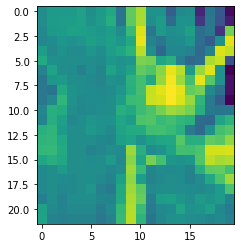

In [43]:
plt.imshow(normalized_lowres)

In [44]:
# finally, lets encapulate this to easily do the rest of the cast
def solve_arbitrary_orientation_tiling_by_char(name,config):
    # do some profiling for fun
    start_time = time.time()
    
    print("Beginning Domino Solver for {}.\n".format(name))
    
    # most of the image loading and preprocessing is still the same
    file_source = guilty_gear_cast[name]
    source_image = mpimg.imread(file_source)
    
    #plt.imshow(source_image)
    
    greyscale_image = convert_image_to_grayscale(source_image)
    best_dim = find_best_dim(greyscale_image,config)
    lores_image = resample_image(greyscale_image,best_dim)
    
    #print("Preprocessing complete, desired dimensions: {}\n".format(best_dim))
    #plt.imshow(lores_image)
    # here's where we  start to diverge
    
    # we need to create the slot system first
    slot_sys = create_slot_system(best_dim[0],best_dim[1])
    #print("Slot system complete: {}\n".format(slot_sys))
    
    
    # then compute the costs
    cost_matrix = compute_domino_costs(slot_sys,lores_image,config)
   # print("Cost Matrix Complete: {}\n".format(cost_matrix))
    
    # then solve
    solution_data = solve_arbitrary_orientation_tiling(slot_sys,cost_matrix,config)
    
    assert solution_data is not None
    
    layout_data = create_domino_layout(solution_data,lores_image.shape,config) 
    # and put it all together in a nice package
    
    end_time = time.time()
    
    output_data = {"name":name,
                   "solution":solution_data,
                   "layout":layout_data,
                   "duration":(end_time-start_time),
                   "num_variables":(slot_sys["total"]*config["set_size"])
                  }
    
    return output_data

In [45]:
# ok, lets test it out on another char/config
pot_sol = solve_arbitrary_orientation_tiling_by_char("Potemkin",new_config)


Beginning Domino Solver for Potemkin.

1


In [46]:
HTML(pot_sol["layout"])

In [47]:
pot_sol["duration"]

34.457332611083984

In [49]:
big_out_config = default_config.copy()
big_out_config["sets"]=9
# lets go big! 
with open("domino_art.html","w") as file:
    file.write("""<html>
	<head>
		<title>Domino Art</title>
	</head>
	<body>""")
    file.write("<p>Each of these artworks are optimized using {} sets of double 9 dominoes in arbitrary orientations.</p>".format(new_config["sets"]))
    
    for k in guilty_gear_cast.keys():
        file.write("<h1>{}</h1>".format(k))
        my_solution = solve_arbitrary_orientation_tiling_by_char(k,big_out_config)
        file.write(my_solution["layout"])
        file.write("<p>Solution time: {} seconds</p>".format(my_solution["duration"]))
        file.write("<p>Number of Variables: {}</p>".format(my_solution["num_variables"]))
    
    file.write("</body></html>")
        
    


Beginning Domino Solver for Sol.

1
Beginning Domino Solver for Ky.

1
Beginning Domino Solver for May.

1
Beginning Domino Solver for Axl.

1
Beginning Domino Solver for Chipp.

1
Beginning Domino Solver for Potemkin.

1
Beginning Domino Solver for Faust.

1
Beginning Domino Solver for Millia.

1
Beginning Domino Solver for Zato.

1
Beginning Domino Solver for Ramlethal.

1
Beginning Domino Solver for Leo.

1
Beginning Domino Solver for Nagoriyuki.

1
Beginning Domino Solver for Giovanna.

1
Beginning Domino Solver for Anji.

1
Beginning Domino Solver for I-no.

1
Beginning Domino Solver for Goldlewis.

1
Beginning Domino Solver for Jack-O.

1
